In [1]:
import re
import math
import pandas as pd
import numpy as np
import mplcursors
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

In [2]:
games = pd.read_csv("./data/games.csv")
players = pd.read_csv("./data/players.csv")
plays = pd.read_csv("./data/plays_with_both.csv").drop(['Unnamed: 0'], axis=1)
weeks = [] 
for i in range(1,18):
    weeks.append(pd.read_csv("./data/week{}_with_both.csv".format(i)).drop(['Unnamed: 0'], axis=1))

In [3]:
def posession(plays_row):
    if games.query("gameId=={}".format(plays_row.gameId)).visitorTeamAbbr.iloc[0] == plays_row.possessionTeam:
        return 'away'
    else:
        return 'home'
    
def get_week(gameID, playID):
    return games.query("gameId=={}".format(gameID)).iloc[0].week - 1
    
def get_week_df(gameID, playID):
    wk = get_week(gameID, playID)
    week_df = weeks[wk]
    information = week_df[(week_df.playId==playID)&(week_df.gameId==gameID)]
    return information, wk

# this function requires 'plays' dataframe
def animate_play(gameID, playID):
    plt.close('all')
    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(14)
    
    information, wk = get_week_df(gameID, playID)
    max_frame = information.frameId.max()
    print("GAME: {}\tPLAY: {}\tWEEK: {}\tFRAME: {}".format(gameID, playID, wk, max_frame))
    
    home, = ax.plot([],[], linestyle='None', marker='o', markersize=12, c='C0')
    away, = ax.plot([],[], linestyle='None', marker='o', markersize=12, c='C1')
    foot, = ax.plot([],[], linestyle='None', marker='o', markersize=12, c='C2')
    lines = [home, away, foot]
    
    def draw_field():
        ax.set_xlim(0, 120)
        ax.set_ylim(-5, 58.3)
        # Endzones
        ax.add_patch(Rectangle((  0, 0), width=10, height=53.3, alpha=0.5, color='grey'))
        ax.add_patch(Rectangle((110, 0), width=10, height=53.3, alpha=0.5, color='grey'))
        # Sidelines
        ax.plot([0,120],[0,0], c='grey', linewidth=2)
        ax.plot([0,120],[53.3,53.3], c='grey', linewidth=2)
        for i in range(10, 120, 10):
            # 10 Yard lines
            ax.plot([i,i],[0,53.3], c='grey', linewidth=2)
            if abs(60-i) <=40:
                # Numbers
                ax.text(i-2.5, 12, str(50-abs(60-i)), color="grey", fontsize=24)
                ax.text(i-2.5, 41.3, str(50-abs(60-i)), color="grey", fontsize=24, rotation=180)
        # Hash marks
        for i in range(10, 110):
            ax.plot([i,i], [0, 1], c='grey')
            ax.plot([i,i], [23, 24], c='grey')
            ax.plot([i,i], [29.3, 30.3], c='grey')
            ax.plot([i,i], [52.3, 53.3], c='grey')
        
        # Drawing the line of scrimmage
        scrimmage = information.query("frameId==1 and displayName=='Football'").iloc[0].x
        ax.plot([scrimmage,scrimmage],[0, 53.3], c='darkblue', linewidth=2)
        
        # Drawing the First Down Line
        play_information = plays.query("playId=={} and gameId=={}".format(playID, gameID)).iloc[0]
        ax.set_title(play_information.playDescription)
        home_team = games[games.gameId==gameID].iloc[0].homeTeamAbbr
        poss_team = play_information.possessionTeam
        team_query_term = "home"
        if home_team != poss_team:
            team_query_term = "away"
        shit = information.query("frameId==1 and team=='{}'".format(team_query_term)).iloc[0].x
        first_down_line = scrimmage - play_information.yardsToGo
        if shit < scrimmage:
            first_down_line = scrimmage + play_information.yardsToGo
        ax.plot([first_down_line,first_down_line],[0, 53.3], c='gold', linewidth=2)
        return lines

    def plot_players(t):
        home_filtered = information[(information.frameId==t)&(information.team=="home")]
        away_filtered = information[(information.frameId==t)&(information.team=="away")]
        foot_filtered = information[(information.frameId==t)&(information.team=="football")]
        home.set_data(home_filtered.x.array, home_filtered.y.array)
        away.set_data(away_filtered.x.array, away_filtered.y.array)
        foot.set_data(foot_filtered.x.array, foot_filtered.y.array)
        lines = [home, away, foot]
        
        if t%10 == 0:
            print(t,end = ',')
        return lines
    
    return animation.FuncAnimation(fig, plot_players, frames=range(1, max_frame+1), init_func=draw_field, blit=True)
    #return animation.FuncAnimation(fig, plot_players, frames=range(20, 21), init_func=draw_field, blit=True)

# What are the most successful/ unsuccessful target-cover pair?
Given that we know who the target and the cover are for each play, we want to know if there is a most successful or most unsuccessful pairings. Success will be determined by whether the pass was complete or incomplete. 

In [4]:
nan = np.nan
playsWithPair = plays.query("target!='-'")
playsWithPair = playsWithPair[~playsWithPair.coverOne.isna()]
playsWithPair = playsWithPair.reset_index(drop=True)
print(str(round(100.0*len(playsWithPair)/len(plays), 1))+"%")

80.1%


We lost about 20% of the plays. I think that's expected. All the plays that resulted in sacks and some other miscellaneous cases. Now, I need to create tabluate pairs and results. To do that, I need to formulate a way to count the countTwo as an equal share holder in the passResult. Let's create this DataFrame:

In [5]:
playsWithPair.head(1)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI,target,coverOne,coverTwo
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pushed ob at ATL 30 for 10 yards (M.Jenkins).,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,Julio Jones,Malcolm Jenkins,NaN


In [6]:
coverTwoExists = playsWithPair[~playsWithPair.coverTwo.isna()]
target = pd.concat([playsWithPair.target, coverTwoExists.target])
cover = pd.concat([playsWithPair.coverOne, coverTwoExists.coverTwo])
passResult = pd.concat([playsWithPair.passResult, coverTwoExists.passResult])
pairResult = pd.DataFrame()
pairResult = pairResult.assign(target=target, cover=cover, passResult=passResult)
pairResult = pairResult.reset_index(drop=True)
pairResult

,target,cover,passResult
0,Julio Jones,Malcolm Jenkins,C
1,Calvin Ridley,Jalen Mills,I
2,Devonta Freeman,Jalen Mills,I
3,Julio Jones,Ronald Darby,C
4,Devonta Freeman,Ronald Darby,I
...,...,...,...
16797,Jerome Cunningham,Ben Gedeon,C
16798,Jared Cook,Josey Jewell,C
16799,Devontae Booker,Erik Harris,C
16800,Courtland Sutton,Erik Harris,I


In [7]:
pairResult.query("passResult=='C'").groupby(['target', 'cover']).count().sort_values("passResult", ascending=False)

passResult
target              cover                         
Davante Adams       Xavier Rhodes               12
Julio Jones         Eli Apple                    9
Christian McCaffrey De'Vondre Campbell           7
Adam Humphries      Captain Munnerlyn            7
Stefon Diggs        Prince Amukamara             7
...                                            ...
Geronimo Allison    Adrian Amos                  1
Gerald Everett      Tramaine Brock               1
                    Sherrick McManis             1
                    Quandre Diggs                1
Jonnu Smith         Denzel Perryman              1

[8684 rows x 1 columns]

Obviously, this does not mean that Xavier Rhodes is the worst cover in the league. Especially, given that Davante Adams is the leagues best WR in general. What I need to look is percentage out of all plays.

In [8]:
pairCompletion= pairResult.query("passResult=='C'").groupby(['target', 'cover']).count().sort_values("passResult", ascending=False)
pairTotal = pairResult.groupby(['target', 'cover']).count().sort_values("passResult", ascending=False)
pairTotal = pairTotal.assign(completionRate=pairCompletion.passResult.divide(pairTotal.passResult, fill_value=0.0))

In [9]:
pairTotal.query("passResult > 7").sort_values(['passResult','completionRate'], ascending=[False, True])

,,passResult,completionRate
target,cover,,
Davante Adams,Xavier Rhodes,14,0.857143
Odell Beckham,James Bradberry,10,0.500000
Julio Jones,Eli Apple,10,0.900000
Antonio Brown,Denzel Ward,9,0.555556
T.Y. Hilton,Jalen Ramsey,8,0.625000
Mike Evans,James Bradberry,8,0.625000
DeAndre Hopkins,Jalen Ramsey,8,0.625000
Michael Thomas,Lavonte David,8,0.875000
Adam Humphries,Captain Munnerlyn,8,0.875000


We can see that most pairs are above 50% except for Odell-James Bradberry pair. I think this is very impressive for James Bradberry.

However, in general, it looks like it's hard to be conclusive when grouped by pairs. The number of samples is too little. I think this makes sense because if the teams identify this pairing is a great matchup (or poor depended on which team you are rooting for), they would most likely switch around to gain favoritism.

# Who are the most successful covers?
Instead of looking at pairs, I think more useful information might be to look at, which cover forced the the lowest completionRate. Note that from here on out, we look at INcompletion rate.

In [10]:
pairIncompletion = pairResult.query("passResult!='C'").groupby('cover').count().sort_values("passResult", ascending=False)
pairTotal = pairResult.groupby('cover').count().sort_values("passResult", ascending=False)
pairTotal = pairTotal.assign(incompletionRate=pairIncompletion.passResult.divide(pairTotal.passResult, fill_value=0.0)).drop('target', axis=1)
pairTotal = pairTotal.rename(columns={'passResult':'coverCount'})[["incompletionRate", "coverCount"]]
pairTotal = pairTotal.sort_values(['coverCount', 'incompletionRate'], ascending=[False, True])

In [11]:
pairTotal

,incompletionRate,coverCount
cover,,
James Bradberry,0.419048,105
Eli Apple,0.352941,102
Adoree' Jackson,0.326733,101
Tremaine Edmunds,0.340206,97
Darius Leonard,0.252632,95
Jamal Adams,0.389474,95
Tyrann Mathieu,0.250000,92
Prince Amukamara,0.336957,92
Shawn Williams,0.307692,91


Well, looks like the 50% incompletion rate is insanely good when you look at this result. What is the baseline here? What is the average incompletionRate in the league?

In [12]:
print("Mean Incompletion Rate:\t" + str(round(pairTotal.incompletionRate.mean(),3)))
print("Mean Cover Count:\t" + str(round(pairTotal.coverCount.mean(), 1)))

Mean Incompletion Rate:	0.304
Mean Cover Count:	31.3


Let's just plot this. It's difficult to see all the numbers:

Index(['Terrell Suggs', 'Darius Slay', 'Za'Darius Smith', 'Stephon Gilmore',
       'James Bradberry', 'Marlon Humphrey', 'Kyle Fuller'],
      dtype='object', name='cover')


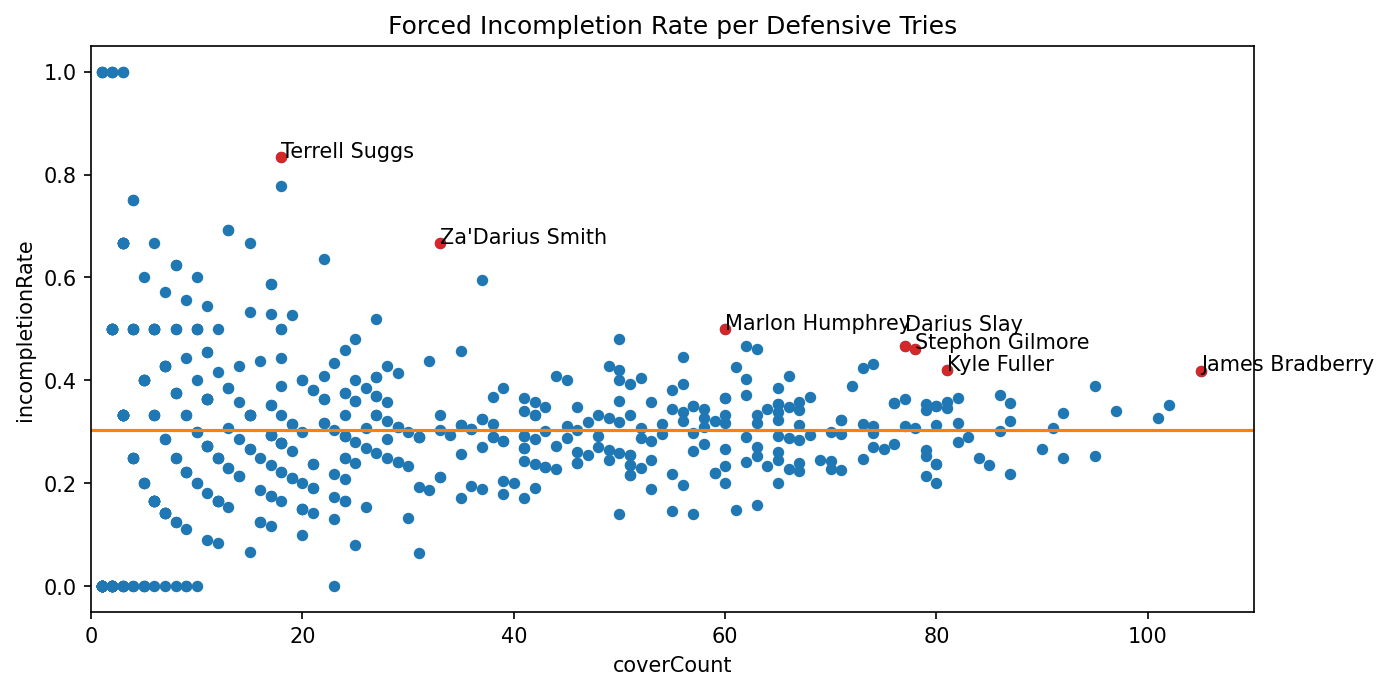

In [140]:
plt.close('all')
ax = pairTotal.plot.scatter(x='coverCount', y='incompletionRate', figsize=(10,5))
plt.plot([-10,130], [pairTotal.incompletionRate.mean(), pairTotal.incompletionRate.mean()], c='C1')

# Finding the players on the edges
tempX = np.arange(0,110,1)
tempY = np.exp(-0.03 * (tempX+10))+0.6
#plt.plot(tempX, tempY, c='C2')

tempDistToLine = []
for i in range(len(pairTotal)):
    p = pairTotal.iloc[i]
    minDist = 100000000
    for j in range(len(tempX)):
        tempdist = math.sqrt((p.coverCount-j)**2+(p.incompletionRate-tempY[j])**2)
        minDist = min(minDist, tempdist)
    tempDistToLine.append(minDist)
temp = pairTotal.assign(dist=tempDistToLine)
edge_points = temp.sort_values('dist', ascending=True)[:7]
edge_points.plot.scatter(x='coverCount', y='incompletionRate',c='C3', ax=ax)
for i in range(len(edge_points)):
    p = edge_points.iloc[i]
    name = edge_points.index[i]
    if 'Darius Slay' in name:
        plt.text(x=p.coverCount, y=p.incompletionRate+0.03, s=name)
    else:   
        plt.text(x=p.coverCount, y=p.incompletionRate, s=name)
print(edge_points.index)


plt.xlim([0, 110])
plt.ylim([-.05, 1.05])
plt.title("Forced Incompletion Rate per Defensive Tries")
plt.show()

We can see that the above 7 players are exceptional when it comes to forcing incompletions.

In [143]:
edge_points.drop('dist', axis=1).sort_values('coverCount', ascending=False)

,incompletionRate,coverCount
cover,,
James Bradberry,0.419048,105
Kyle Fuller,0.419753,81
Stephon Gilmore,0.461538,78
Darius Slay,0.467532,77
Marlon Humphrey,0.500000,60
Za'Darius Smith,0.666667,33
Terrell Suggs,0.833333,18
